In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import os,glob

In [2]:
Trigs = ['200309_5mVPMT']
wDir = '/data/share/KA0219/DR'
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob(wDir+'/*.bin')]
fWaves.sort()
fWaves

['/data/share/KA0219/DR/1786V_200710_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E1_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E2_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E4_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E5_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E6_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E7_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E8_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_E9_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_W1_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_W2_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_W3_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_W4_200722_100_samples_100000_events',
 '/data/share/KA0219/DR/1786V_W5_200722_100_samples_100000_events']

In [3]:
waveArrs = [au.ReadDDC10_BinWave(iRun) for iRun in fWaves]
waveArrs

[[array([[[-0.00219727, -0.00256348, -0.00231934, ..., -0.00231934,
           -0.00219727, -0.00195312],
          [ 0.00061035,  0.00036621,  0.00024414, ...,  0.00012207,
            0.00048828,  0.00012207]],
  
         [[-0.0020752 , -0.00231934, -0.00170898, ..., -0.00195312,
           -0.00170898, -0.00256348],
          [ 0.00048828,  0.00024414,  0.00048828, ...,  0.00012207,
            0.00036621,  0.00048828]],
  
         [[-0.00256348, -0.00317383, -0.0020752 , ..., -0.00256348,
           -0.00219727, -0.0020752 ],
          [ 0.00048828,  0.00061035,  0.00048828, ...,  0.00061035,
            0.        ,  0.00024414]],
  
         ...,
  
         [[-0.00219727, -0.00195312, -0.00146484, ..., -0.00268555,
           -0.00244141, -0.00219727],
          [ 0.00024414,  0.00024414,  0.00024414, ...,  0.00048828,
            0.00012207,  0.00061035]],
  
         [[-0.0020752 , -0.00231934, -0.0020752 , ..., -0.00231934,
           -0.00158691, -0.00219727],
          [ 0

In [4]:
def getChargeHist(wave,waveinfo,init=40,iend=55,nBins=1000,hrange=[-10,20]):
    wave = au.Subtract_Baseline(wave,30)[0]
    qArr = 1e3*integrate.simps(wave[...,init:iend],axis=2)
    qArr *=au.sampleWidth_ns/au.resistance_ohm
    return np.histogram(qArr,bins=nBins,range=hrange,weights=np.ones(shape=qArr.shape)/waveinfo['totliveTime_s'])

In [5]:
waveArrs[0][0].shape

(100000, 2, 100)

(array([50.87900493, 21.98288016, 20.81639002, 20.70437217, 16.69785266]),
 array([1.59544817e+09, 1.59544962e+09, 1.59544986e+09, 1.59545014e+09,
        1.59545046e+09]))

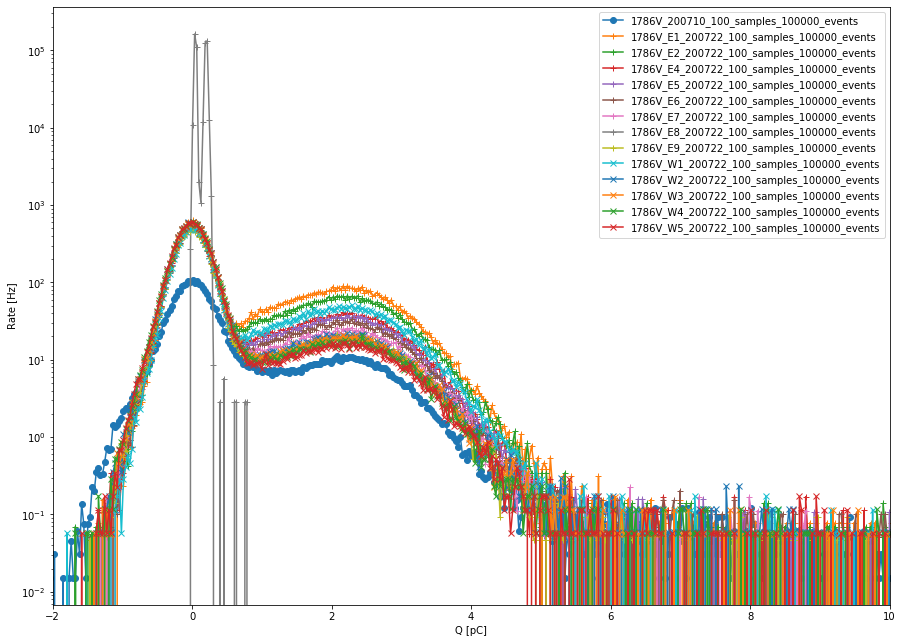

In [7]:
DW = np.zeros(5)
WT = np.zeros(5)
iD=0
DE = np.zeros(8)
ET = np.zeros(8)
iE=0
for iW in range(len(waveArrs)):
    qHist,qHistEdges = getChargeHist(waveArrs[iW][0],waveArrs[iW][1])
    lab = os.path.basename(fWaves[iW])
    mark = 'o'
    minQ = np.argmax(qHistEdges>1)
    if 'W' in fWaves[iW]:
        mark ='x'
        DW[iD] = np.max(qHist[minQ:])
        WT[iD] = os.stat(fWaves[iW]+'.log').st_mtime
        iD+=1
    if 'E' in fWaves[iW]:
        mark ='+'
        DE[iE] = np.max(qHist[minQ:])
        ET[iE] = os.stat(fWaves[iW]+'.log').st_mtime
        iE+=1
    plt.plot((qHistEdges[1:]+qHistEdges[:-1])/2,qHist,label=lab,marker=mark)
plt.yscale('log')
plt.xlim(-2,10)
plt.xlabel('Q [pC]')
plt.ylabel('Rate [Hz]')
plt.legend()
DW,WT

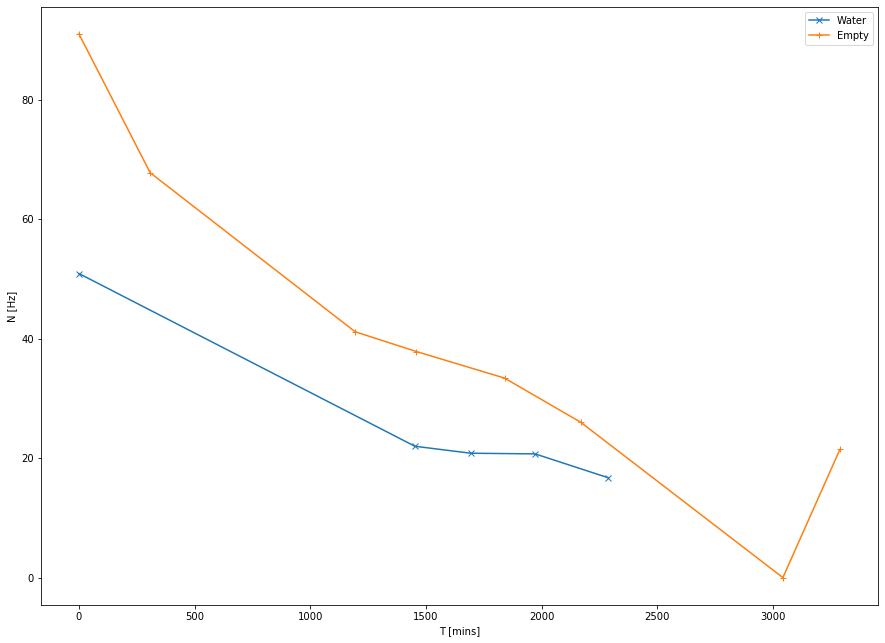

In [8]:
plt.plot(WT-WT[0],DW,label='Water',marker='x')
plt.plot(ET-ET[0],DE,label='Empty',marker='+')
plt.xlabel('T [mins]')
plt.ylabel('N [Hz]')
plt.legend()

In [ ]:
plt.plot(waveArrs[-1][0][:,0].sum(0))

In [ ]:
au.plotWaves(waveArrs[-1][0])

In [20]:
#1pC bin
bin1pc = np.argmax(qHistEdges>1)
bin10pc = np.argmax(qHistEdges>10)
bin1pc

424

In [18]:
print('Integrated Rate > 1pC = '+str(np.sum(qHist[bin1pc:]))+' Hz')

Integrated Rate > 1pC = 959.369666434404 Hz


In [10]:
from scipy.optimize import curve_fit
